- 落札されているオークションは除外する
- 乱数設定
- 以前の候補数は4億

In [149]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta
import pathlib
import re
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [150]:
pd.set_option('display.max_columns', 50)

In [151]:
# %load_ext autoreload
# %autoreload 2
import brandear_est as be

In [152]:
SUB_DIR = os.path.join(os.getcwd(), "../../data/submit")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_RANK_WEEKLY_DIR = os.path.join(IMD_DIR, "rank_weekly")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_rank_weekly")
IMD_VALID_AUCS_DIR = os.path.join(IMD_DIR, "valid_aucs")

dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [153]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()

In [154]:
# ブランド作成日
brand = be.read_csv(os.path.join(INPUT_DIR , "brand.csv"))
# itemcolorid付与(色の大分類)
color = be.read_csv(os.path.join(INPUT_DIR , "color.csv"))
# カテゴリーid,itemdailID付与のためのItemShouID付与
genre = be.read_csv(os.path.join(INPUT_DIR , "genre.csv"))
# itemshowID,itemdailID付与
itemshou = be.read_csv(os.path.join(INPUT_DIR , "itemshou.csv"))
# itemlineID付与
line = be.read_csv(os.path.join(INPUT_DIR , "line.csv"))

Mem. usage decreased to  0.32 Mb (15.0% reduction)
Mem. usage decreased to  0.01 Mb (32.2% reduction)
Mem. usage decreased to  0.00 Mb (45.4% reduction)
Mem. usage decreased to  0.00 Mb (33.4% reduction)
Mem. usage decreased to  0.01 Mb (41.3% reduction)


In [155]:
# オークション情報拡充
def rename(df, prefix):
    target_columns = ["ModifyDate", "CreateDate"]
    for target_column in target_columns:
        if target_column in df.columns:
            df.rename(columns={target_column: prefix + target_column}, inplace=True)
    return df

itemshou = rename(itemshou, prefix="ItemShow")
genre = rename(genre, prefix="Genre")
brand = rename(brand, prefix="Brand")
color = rename(color, prefix="Color")
line = rename(line, prefix="Line")

genre_mst = (
    genre[["GenreID", "ItemShouID", "CategoryID"]]
    .merge(itemshou[["ItemShouID", "ItemDaiID"]], on="ItemShouID", how="inner")
)

auction_mst = (
    auction
    .merge(genre_mst, on="GenreID", how="left")
    .merge(brand[["BrandID", "BrandCreateDate"]], on="BrandID", how="left")    
    .merge(color[["ColorID", "ItemColorID"]], on="ColorID", how="left")    
    .merge(line[["LineID", "ItemLineID", "LineCreateDate"]], on="LineID", how="left")        
    .fillna(0)
)
auction_mst = be.to_datetime(auction_mst[sorted(list(auction_mst.columns))])

In [156]:
def extract_target_actions(watch, bid, period):
    watch_actioned = (
        watch.loc[(watch["TourokuDate"] >= period["oldest"]) & (watch["TourokuDate"] < period["newest"]),
                  ["KaiinID", "AuctionID"]]
    )
    bid_actioned = (
        bid.loc[(bid["ShudouNyuusatsuDate"] >= period["oldest"]) & (bid["ShudouNyuusatsuDate"] < period["newest"]),
                ["KaiinID", "AuctionID"]]
    )
    # 学習用データの際は正解データを作成する
    watch_actioned["watch_actioned"] = 1
    bid_actioned["bid_actioned"] = 1

    target_actions = (
        watch_actioned
        .merge(bid_actioned, on=["KaiinID", "AuctionID"], how="outer")
        .drop_duplicates()
        .fillna(0)
    )

    return target_actions


def build_target_candidate(actions, auc_dataset, period, target_users, target_col, dset_type, target_actions):
        
    users_auc_cands_cross = None
    
    if dset_type == "submission":
        # 有望オークションと、ユーザーとのクロスジョインから候補作成        
        users_auc_cands_cross = be.cross_join(target_users, auc_dataset)
    else:
        # クロスジョイン後正解データをジョイン
        users_auc_cands_cross = (
            be.cross_join(target_users, auc_dataset)
            .merge(target_actions, on=["KaiinID", "AuctionID"], how="left")
            .fillna(0)
        )
                
    return users_auc_cands_cross


def extract_similar_aucs(target_users, auction, actions, period):
    similar_aucs = (
        actions.merge(target_users, on="KaiinID", how="inner")
            .merge(auction, on="ShouhinID")
    )
    return similar_aucs

In [157]:
def arrange_dtime_condition(watch, bid, bid_success, auction, period):
    retval = ((
        watch[watch["TourokuDate"] <= period["oldest"]],
        bid[bid["ShudouNyuusatsuDate"] <= period["oldest"]],
        bid_success[bid_success["RakusatsuDate"] < period["oldest"]],
        auction[auction["CreateDate"] < period["newest"]]
    ))
    return retval
    

def arrange_inputs(watch, bid, bid_success, auction, period):
    
    target_actions = extract_target_actions(watch, bid, period)
    
    watch_t, bid_t,  bid_success_t, auction_t = (
        arrange_dtime_condition(watch, bid, bid_success, auction, period)
    )
    
    arranged_inputs = (
        watch_t.merge(auction_t, on="AuctionID", how="left"),
        bid_t.merge(auction, on="AuctionID", how="left"),
        bid_success_t.merge(auction, on="AuctionID", how="left"),
        auction_t,
        target_actions
    )
    return arranged_inputs

In [158]:
def df2comp_pkl(df, output_dir, filename):
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, filename), mode="wb") as f:
        joblib.dump(df, f, compress=3)

In [159]:
# tr_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/train.pkl")
vt_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/valid_for_train.pkl")
vs_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/valid_for_sub.pkl")
# sub_dataset_input = pd.read_pickle(IMD_VALID_AUCS_DIR + "/submission.pkl")

In [161]:
# %%time

auc_attr_col = [
    "AuctionID", "ShouhinID", "BrandID", "ItemShouID",
    "SaishuppinKaisuu", "SankouKakaku", "1m_watch_AuctionID_cnt", "1m_watch_ShouhinID_cnt", "1m_watch_ItemShouID_cnt",
    "elapsed_days", "watch_elapsed_days"
]

target_col = "watch_actioned"

dataset_inputs = {
#     "train": watch_train_dataset,
#     "valid_for_train": vt_dataset_input,
#     "valid_for_sub": vs_dataset_input
    "submission": sub_dataset_input
}

valid_auc_th = 0.1

for dset_type, dataset_input in dataset_inputs.items():
        
    auc_dataset = dataset_input.query(f"pred >= {valid_auc_th}")[auc_attr_col]
    
    watch_arranged, bid_arranged, bid_success_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, bid_success=bid_success, auction=auction_mst, period=dset_to_period[dset_type])
    )

    # 特徴量作成
    w_k_cnts = be.cross_counts(watch_arranged, "KaiinID")
    w_ka_cnts = be.cross_counts(watch_arranged, ["KaiinID", "AuctionID"])
    w_ks_cnts = be.cross_counts(watch_arranged, ["KaiinID", "ShouhinID"])
    w_kb_cnts = be.cross_counts(watch_arranged, ["KaiinID", "BrandID"])
    w_ki_cnts = be.cross_counts(watch_arranged, ["KaiinID", "ItemShouID"])
    
    actions = (
        pd.concat([watch_arranged, bid_arranged], sort=False)[["AuctionID", "KaiinID", "ShouhinID"]]
        .drop_duplicates().drop("AuctionID", axis=1)
    )
    
    targets = None
    
    if dset_type != "submission":
        targets = target_actions.sort_values("KaiinID").reset_index(drop=True)[["KaiinID"]].drop_duplicates()
    else:
        targets = sub_users
        
    
    for g, split_targets in targets.groupby(targets["KaiinID"] // 5000):
        
        print(dset_type, "分割",g, "番目")        
        if (g > 10) & (dset_type == "valid_for_train") : continue

        splited_candidates = build_target_candidate(
            actions=actions,
            auc_dataset=auc_dataset[auc_attr_col],
            period=dset_to_period[dset_type],
            target_users=split_targets,
            target_col=target_col,
            dset_type=dset_type,
            target_actions=target_actions
        )
        
        splited_candidates_feat = (
            splited_candidates
            .merge(w_k_cnts, on="KaiinID", how="left")
            .merge(w_ka_cnts, on=["KaiinID", "AuctionID"], how="left")
            .merge(w_ks_cnts, on=["KaiinID", "ShouhinID"], how="left")
            .merge(w_kb_cnts, on=["KaiinID", "BrandID"], how="left")
            .merge(w_ki_cnts, on=["KaiinID", "ItemShouID"], how="left")
            .drop(["ShouhinID", "BrandID", "ItemShouID"], axis=1)
            .fillna(0)
        )
        
        splited_candidates_feat["BrandID_KaiinID_rate"] = (
            splited_candidates_feat["KaiinID_BrandID_cnt"] / splited_candidates_feat["KaiinID_cnt"]
        ).fillna(0)
        splited_candidates_feat["ItemShouID_KaiinID_rate"] = (
            splited_candidates_feat["KaiinID_ItemShouID_cnt"] / splited_candidates_feat["KaiinID_cnt"]
        ).fillna(0)
        
        splited_candidates_feat.drop(["KaiinID_BrandID_cnt", "KaiinID_ItemShouID_cnt"], axis=1, inplace=True)
        
        df2comp_pkl(splited_candidates_feat, IMD_ARCHIVE_DIR + "/"  + dset_type + "/", f"split_cands_{g}.pkl")

submission 分割 0 番目
submission 分割 1 番目
submission 分割 2 番目
submission 分割 3 番目
submission 分割 4 番目
submission 分割 5 番目
submission 分割 6 番目
submission 分割 7 番目
submission 分割 8 番目
submission 分割 9 番目
submission 分割 10 番目
submission 分割 11 番目
submission 分割 12 番目
submission 分割 13 番目
submission 分割 14 番目
submission 分割 15 番目
submission 分割 16 番目
submission 分割 17 番目
submission 分割 18 番目
submission 分割 19 番目
submission 分割 20 番目
submission 分割 21 番目
submission 分割 22 番目
submission 分割 23 番目
submission 分割 24 番目
submission 分割 25 番目
submission 分割 26 番目
submission 分割 27 番目
submission 分割 28 番目
submission 分割 29 番目
submission 分割 30 番目
submission 分割 31 番目
submission 分割 32 番目
submission 分割 33 番目
submission 分割 34 番目
submission 分割 35 番目
submission 分割 36 番目
submission 分割 37 番目
submission 分割 38 番目
submission 分割 39 番目
submission 分割 40 番目
submission 分割 41 番目
submission 分割 42 番目
submission 分割 43 番目
submission 分割 44 番目
submission 分割 45 番目
submission 分割 46 番目
submission 分割 47 番目
submission 分割 48 番目
submission 分割 49 番目
submission

In [162]:
def read_comp_pkl(path):
    with open(path, mode="rb") as f:
        retval = joblib.load(f)    
    return retval

In [163]:
drop_cols = ["KaiinID", "AuctionID", "bid_actioned", "watch_actioned"]
target_col="watch_actioned"

# vs_dataset_input = read_comp_pkl(IMD_ARCHIVE_DIR + "/valid_for_sub/split_cands_8.pkl").drop_duplicates()
# vs_dataset = be.DataSet(data=vs_dataset_input,drop_cols=drop_cols, target_col=target_col)

In [164]:
%%time
## 予測

dset_pairs = [
    {"old": "valid_for_sub", "new": "submission"}
]
for dset_pair in dset_pairs:

    paths = (
        sorted([p for p in pathlib.Path(IMD_ARCHIVE_DIR + "/" + dset_pair['old']).iterdir()
               if os.path.basename(p) != ".DS_Store"])[:10]
    )
    df_buf = []
    for path in paths:
        print(path)
        with open(path, mode="rb") as f:
            tmp_df = joblib.load(f).drop_duplicates()
#             tmp_df = joblib.load(f)
        df_buf.append(
            tmp_df.query("(watch_actioned == 1) | (bid_actioned == 1)").sample(frac=1, random_state=1).groupby("KaiinID").head(4)
        )
        df_buf.append(
            tmp_df.query("(watch_actioned != 1) & (bid_actioned != 1)").sample(frac=0.01, random_state=1).groupby("KaiinID").head(200)
        )
    dataset_input = pd.concat(df_buf)

    vt_dataset = be.DataSet(data=dataset_input,drop_cols=drop_cols, target_col="watch_actioned")
    lgb_bi = be.LgbBinaryClassifier()
    lgb_bi.train(train_dataset=vt_dataset, desc=True)    

    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + "/" + dset_pair["new"]).iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        sub_dataset = be.DataSet(data=read_comp_pkl(path), drop_cols=drop_cols, target_col=target_col)        
        pred = lgb_bi.predict(sub_dataset)
        sub_dataset.set_pred(pred)
        
        df2comp_pkl(sub_dataset.data, IMD_ARCHIVE_DIR + f"/{dset_pair['new']}_pred/", os.path.basename(path)) 
        os.remove(path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/arc_rank_weekly/valid_for_train'

In [165]:
%%time
## 予測値上位の候補を出力
target_col = "watch_actioned"
th = 1600
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    choiced_cands_buf = []    
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + f"/{dset_type}_pred/").iterdir()):
        print(path)
        if os.path.basename(path) == ".DS_Store": continue
        splited_action_cands = (
            read_comp_pkl(path)
            .sort_values(['KaiinID', 'pred'], ascending=[True, False])
        )
        splited_action_cands['rank'] = splited_action_cands.groupby('KaiinID')['pred'].cumcount()        
        choiced_cands = splited_action_cands.query(f"rank <= {th}")
        choiced_cands_buf.append(choiced_cands)

    be.df2pkl(pd.concat(choiced_cands_buf), IMD_RANK_WEEKLY_DIR, f"{dset_type}_{th}_tmp.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nobuyuki.ishida/Practice/competition/nishika/Brandear/code/brandear_est/../../data/intermediate/arc_rank_weekly/valid_for_sub_pred'

In [41]:
def stack_target_actions(target_actions):
    watch_target = target_actions.query("(watch_actioned == 1)")[["KaiinID", "AuctionID"]]
    bid_target = target_actions.query("(bid_actioned == 1)")[["KaiinID", "AuctionID"]]
    watch_target["score"] = 1
    bid_target["score"] = 2
    stacked_target_actions = pd.concat([watch_target, bid_target], sort=False)
    return stacked_target_actions

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    return np.sum((2 ** r - 1) / np.log2(np.arange(2, r.size + 2)))


def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max


def calc_ndcg(y_true, y_pred, k=20):
    y_pred_cp = y_pred.copy()

    actione_true = stack_target_actions(y_true)
    actione_true["rank"] = 100

    y_pred_cp['rank'] = y_pred_cp.groupby('KaiinID')['AuctionID'].cumcount()

    scored_pred = (
        y_pred_cp.merge(actione_true[["KaiinID", "AuctionID", "score"]], on=["KaiinID", "AuctionID"],
                        how="left").fillna(0))

    unchoiced_actiones = (
        be.left_anti_join(actione_true, y_pred_cp, ["KaiinID", "AuctionID"], ["KaiinID", "AuctionID"]))

    scored_actiones = (
        pd.concat([scored_pred, unchoiced_actiones], sort=False)
            .sort_values(["KaiinID", "rank"], ascending=["True", "True"]))

    dcgs = scored_actiones.groupby("KaiinID")["score"].apply(lambda s: ndcg_at_k(s.tolist(), k=20))
#     ndcg = dcgs.mean()

    return dcgs


In [133]:
tmp = pd.read_pickle(IMD_RANK_WEEKLY_DIR + "/watch_valid_for_sub_1600.pkl")[["AuctionID", "KaiinID"]].drop_duplicates()

dset_type = "valid_for_sub"

watch_arranged, bid_arranged, bid_success_arranged, auction_arranged, target_actions = (
    arrange_inputs(watch=watch, bid=bid, bid_success=bid_success, auction=auction_mst, period=dset_to_period[dset_type])
)

tmp_sim = extract_similar_aucs(
    target_users=target_actions[["KaiinID"]].drop_duplicates(),
    auction=auction_arranged,
    actions=pd.concat([watch_arranged, bid_arranged])[["KaiinID", "ShouhinID"]],
    period=dset_to_period[dset_type]
)[["AuctionID", "KaiinID"]].drop_duplicates()

cheat_pred = be.get_cheat_pred(
    data=pd.concat([tmp]).drop_duplicates() ,
    target_actions=target_actions
)

cheat_sub = be.adjust_sub_form(target_actions[["KaiinID"]].drop_duplicates(), cheat_pred, drop=True)
dcgs = calc_ndcg(target_actions, cheat_sub)
print(dcgs.mean())

/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


0.28234715074670846


(array([3.917e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.000e+00,
        9.000e+00, 1.200e+01, 2.300e+01, 2.000e+01, 6.000e+00, 3.500e+01,
        1.200e+01, 1.700e+01, 1.130e+02, 3.500e+01, 3.100e+01, 3.400e+01,
        4.200e+01, 2.200e+01, 5.300e+01, 3.000e+01, 3.300e+01, 1.190e+02,
        3.300e+01, 5.300e+01, 2.300e+01, 5.400e+01, 1.700e+01, 2.400e+01,
        9.800e+01, 1.400e+01, 2.800e+01, 8.500e+01, 2.500e+01, 3.100e+01,
        5.500e+01, 3.100e+01, 3.300e+01, 6.400e+01, 1.900e+01, 5.500e+01,
        1.400e+01, 2.400e+01, 3.000e+01, 1.700e+01, 1.150e+02, 1.200e+01,
        2.200e+01, 3.000e+01, 1.600e+01, 3.200e+01, 1.200e+01, 1.300e+01,
        7.000e+00, 3.400e+01, 3.200e+01, 1.200e+01, 2.300e+01, 5.000e+00,
        2.600e+01, 1.140e+02, 4.000e+00, 2.600e+01, 3.300e+01, 1.500e+01,
        6.000e+00, 7.000e+00, 9.000e+00, 8.000e+00, 9.000e+00, 6.000e+00,
        2.400e+01, 6.000e+00, 3.000e+00, 2.000e+00, 3.000e+01, 8.000e+00,
        0.000e+00, 2.100e+01, 4.000e+0

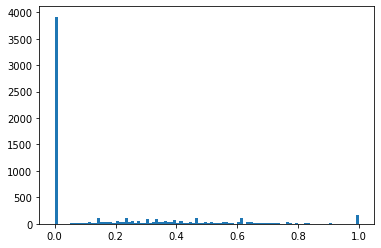

In [119]:
plt.hist(dcgs, bins=100)

In [113]:
target_actions.merge(tmp, on=["KaiinID", "AuctionID"])[["watch_actioned", "bid_actioned"]].sum()

watch_actioned    5781.0
bid_actioned      1440.0
dtype: float64

In [79]:
tmp_sim.shape

(625650, 2)

In [77]:
target_actions.merge(tmp[["KaiinID"]].drop_duplicates(), on="KaiinID").merge(tmp, on=["KaiinID", "AuctionID"])

,KaiinID,AuctionID,watch_actioned,bid_actioned
0,16624,389994,1.0,0.0
1,16624,3978324,1.0,0.0
2,16624,843549,1.0,0.0
3,28440,1371989,1.0,0.0
4,28440,2950880,1.0,0.0
...,...,...,...,...
1124,35338,957825,0.0,1.0
1125,35338,3603726,0.0,1.0
1126,43876,2905429,0.0,1.0
1127,43876,4014953,0.0,1.0


In [73]:
cheat_pred[["score"]].sum()

score    2770.0
dtype: float64

In [68]:
cheat_pred[["KaiinID"]].nunique()

KaiinID    1026
dtype: int64

In [71]:
print(cheat_sub.shape)
print(cheat_sub[["KaiinID"]].nunique())

(20520, 2)
KaiinID    1026
dtype: int64


In [65]:
dcgs.describe()

count    1026.000000
mean        0.252026
std         0.319217
min         0.000000
25%         0.000000
50%         0.000000
75%         0.469395
max         1.000000
Name: score, dtype: float64

(array([537.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   4.,   0.,
          3.,   0.,   1.,  15.,   6.,   5.,   1.,   2.,   4.,   7.,   3.,
          3.,  23.,   3.,   8.,   2.,   9.,   1.,   2.,  21.,   0.,   3.,
         16.,   0.,   1.,   9.,   6.,   7.,  17.,   4.,   6.,   3.,   2.,
          7.,   2.,  27.,   4.,   4.,   7.,   7.,   4.,   3.,   1.,   8.,
          8.,   5.,   0.,   6.,   2.,   9.,  21.,   4.,   4.,  12.,   8.,
          2.,   4.,   3.,   5.,   4.,   0.,  10.,   3.,   1.,   0.,   8.,
          2.,   4.,   6.,   4.,   0.,   5.,   3.,   1.,   3.,   1.,   2.,
          2.,   1.,   2.,   2.,   0.,   4.,   0.,   2.,   0.,   1.,   0.,
         52.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

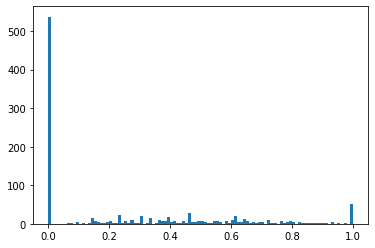

In [58]:
plt.hist(dcgs, bins=100)

(array([543.,  37.,  61.,  81.,  66.,  46.,  70.,  38.,  22.,  62.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

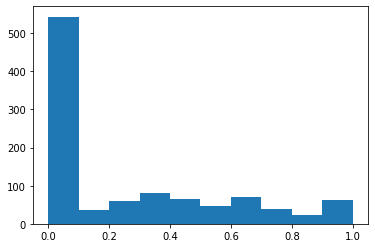

In [45]:
plt.hist(dcgs)

In [94]:
%%time
## 件数を取得
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    cnt_sum = 0
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + f"/{dset_type}/").iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        cnt_sum += read_comp_pkl(path).shape[0]

print(cnt_sum)

KeyboardInterrupt: 

In [12]:
# フィルターをかける前のデータにどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    target_actions_cnt = 0
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    for i, path in enumerate(pathlib.Path(IMD_ARCHIVE_DIR + f"/watch_{dset_type}_feature_pred/").iterdir()):
        if os.path.basename(path) == ".DS_Store": continue
        splited_action_cands = pd.read_pickle(path)
        target_actions_cnt += splited_action_cands[["AuctionID", "KaiinID"]].merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0]
    print(dset_type)
    print(target_actions_pair.shape[0])
    print(target_actions_cnt)

valid_for_sub
91044
44055


In [19]:
## フィルターをかけた後にどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    choiced = pd.read_pickle(IMD_RANK_WEEKLY_DIR +  f"/watch_{dset_type}.pkl")[["AuctionID", "KaiinID"]]
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    print(dset_type)
    print(target_actions_pair.shape[0])
    print(choiced.merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0])

valid_for_sub
91044
15846


In [32]:
## 商品紐付けのみでどのくらいの正解データがあるか
dset_types = ["valid_for_sub"]
for dset_type in dset_types:
    target_actions_pair = (
        extract_target_actions(watch, bid, dset_to_period[dset_type])[["AuctionID", "KaiinID"]].drop_duplicates()
    )
    watch_arranged, bid_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, auction=auction, period=dset_to_period[dset_type])
    )
    similar_aucs = extract_similar_aucs(
        target_users=target_actions_pair[["KaiinID"]].drop_duplicates(), auction=auction,
        actions=pd.concat([watch_arranged, bid_arranged])[["KaiinID", "ShouhinID"]].drop_duplicates(), period=dset_to_period[dset_type]
    )

    print(dset_type)
    print(similar_aucs.shape[0])
    print(target_actions_pair.shape[0])
    print(similar_aucs.merge(target_actions_pair, on=["AuctionID", "KaiinID"]).shape[0])

/Users/nobuyuki.ishida/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


valid_for_sub
3445777
91044
6731


watch
auc :  0.8984988936359313


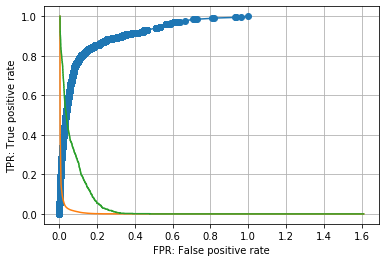

In [299]:
# 推定の精度
tmp = pd.read_pickle(path)
sub_dataset = be.DataSet(data=tmp, drop_cols=drop_cols, target_col=target_col)

target = "watch"
dataset = sub_dataset
print(target)
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
be.plot_roc_curve(dataset.get_target(), dataset.data.pred)
be.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)

In [9]:
tmp = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_train_feature_pred/split_cands_0.pkl")